# Image Segmentation of Spiral Galaxies

This notebook provides a detailed insight into the process that goes into the segmentation of spiral arms from images of spiral galaxies. This notebook accompanies the final year research project I completed for my Masters Degree in Professional Engineering (Software) at University of WA. The dataset used for this notebook is adapted from images retrieved from the 2nd public data release from the HSC data archive system, which is operated by Subaru Telescope and Astronomy Data Center at National Astronomical Observatory of Japan and classification of spiral galaxies from this dataset was achieved by [Tadaki et al.](https://arxiv.org/pdf/2006.13544.pdf) and all image content is a product of their work. You can register to access the HSC Data [here](https://hsc-release.mtk.nao.ac.jp/doc/index.php/data-access__pdr3/).

## [1] Install Dependencies

Here we will run the imports for packages that are used commonly throughout the notebook. Any other required packages will be imported within the code cell that they are required.

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

## [2] Data Pre-Processing

This section covers the functionality used to process the data prior to it being used in training the segmentation model. These functions take the images from the dataset (in the format of `.jpg` and `.tif` files) to a data format that is usable by the Tensorflow Keras API. To achieve a concise pipeline, a Keras Sequence class is used to load and vectorize the data before training the model.

### Configure Location of Data and Training Parameters

In [2]:
images_dir = '/kaggle/input/galaxy-segmentation-set-1/images'
masks_dir = '/kaggle/input/galaxy-segmentation-set-1/masks_png'
img_size = (64, 64)

val_split = 15 # % of total dataset to be used for validation
test_split = 15 # % of total dataset to be used for testing

batch_size = 32 # batch size per step
epochs = 20 # max number of epochs for training
steps_per_epoch = 200 # number of batches processed for each epoch

### Load Dataset and Split Into Subsets

In [3]:
from tensorflow.keras.utils import image_dataset_from_directory, split_dataset

images_ds = image_dataset_from_directory(images_dir, 
                                         labels=None, 
                                         color_mode='grayscale', 
                                         shuffle=False, 
                                         image_size=img_size, 
                                         batch_size=batch_size)

masks_ds = image_dataset_from_directory(masks_dir, 
                                        labels=None, 
                                        color_mode='grayscale', 
                                        shuffle=False, 
                                        image_size=img_size, 
                                        batch_size=batch_size)

dataset = tf.data.Dataset.zip((images_ds, masks_ds))

train_ds, test_ds = split_dataset(dataset, 
                                 right_size=test_split/100, 
                                 shuffle=False)

train_ds, val_ds = split_dataset(train_ds, 
                                 right_size=val_split/(100-test_split), 
                                 shuffle=False)

Found 100 files belonging to 1 classes.
Found 100 files belonging to 1 classes.


### Implement Data Augmentation Pipeline

Using in-built Keras preprocessing sequential layers, here we build a pipeline that can be used to augment the training images from the dataset.

In [4]:
def augment(image, mask):
    
    aug_model = keras.Sequential(
        layers = [
            layers.RandomFlip(mode="horizontal"),
            layers.RandomRotation((-0.25, 0.25), fill_mode="constant", fill_value=0),
            layers.RandomTranslation((-0.25, 0.25),(-0.25, 0.25), fill_mode="constant", fill_value=0),
            #layers.RandomZoom((-0.1, 0.05),(-0.1, 0.05)),
        ]
    )

    image_mask = tf.concat([image, mask], -1)
    image_mask = aug_model(image_mask)
    
    image = image_mask[:,:,:,0]
    mask = image_mask[:,:,:,1]
    
    image = tf.reshape(image, [-1, img_size[0], img_size[1], 1])
    mask = tf.reshape(mask, [-1, img_size[0], img_size[1], 1])
    
    return image, mask

aug_dataset = (
	train_ds
    .cache()
    .shuffle(50)
    .repeat()
    .map(lambda x, y: augment(x, y))
    .prefetch(buffer_size=tf.data.AUTOTUNE)
)

### Demonstrate Data is Loaded Correctly

The following plot should correctly display 4 examples from the augmented dataset of overlayed image segmentations.

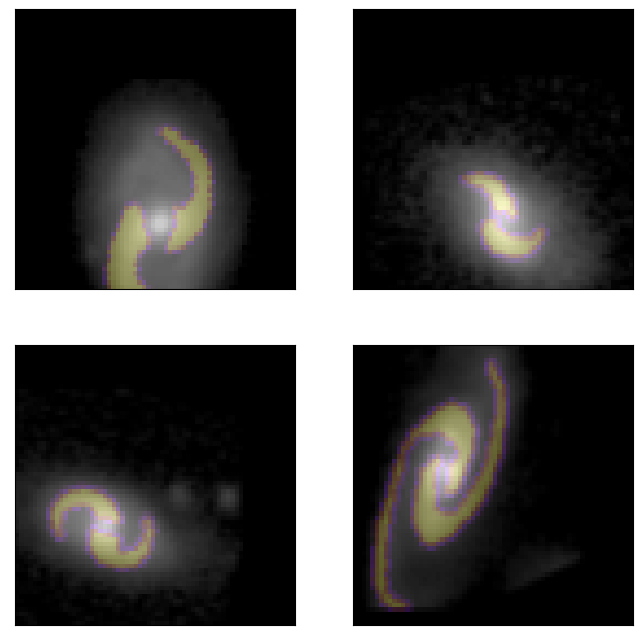

In [5]:
plt.figure(figsize=(8,8))

offset = np.random.randint(60)

for n, (image, mask) in aug_dataset.unbatch().take(4).enumerate(start=offset).as_numpy_iterator():
    
    plt.subplot(2,2,n-offset+1)
    plt.imshow(image, cmap='gray')
    plt.imshow(mask, cmap='gnuplot', alpha=0.2)
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    
plt.show()

## [3] Build Model

In [6]:
def get_unet():
    
    inputs = keras.Input(shape=img_size + (1,))
    
    c1 = layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(inputs)
    c1 = layers.Dropout(0.1)(c1)
    c1 = layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
    p1 = layers.MaxPooling2D((2, 2))(c1)

    c2 = layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
    c2 = layers.Dropout(0.1)(c2)
    c2 = layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
    p2 = layers.MaxPooling2D((2, 2))(c2)

    c3 = layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
    c3 = layers.Dropout(0.2)(c3)
    c3 = layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
    p3 = layers.MaxPooling2D((2, 2))(c3)

    c4 = layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
    c4 = layers.Dropout(0.2)(c4)
    c4 = layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
    p4 = layers.MaxPooling2D(pool_size=(2, 2))(c4)

    c5 = layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p4)
    c5 = layers.Dropout(0.3)(c5)
    c5 = layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)

    u6 = layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5)
    u6 = layers.concatenate([u6, c4])
    c6 = layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u6)
    c6 = layers.Dropout(0.2)(c6)
    c6 = layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)

    u7 = layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c6)
    u7 = layers.concatenate([u7, c3])
    c7 = layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u7)
    c7 = layers.Dropout(0.2)(c7)
    c7 = layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c7)

    u8 = layers.Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c7)
    u8 = layers.concatenate([u8, c2])
    c8 = layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u8)
    c8 = layers.Dropout(0.1)(c8)
    c8 = layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c8)

    u9 = layers.Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c8)
    u9 = layers.concatenate([u9, c1], axis=3)
    c9 = layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u9)
    c9 = layers.Dropout(0.1)(c9)
    c9 = layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c9)

    outputs = layers.Conv2D(1, (1, 1), activation='sigmoid')(c9)
    
    return keras.Model(inputs, outputs, name='U-Net')

## [4] Train Model

In [7]:
import time

model = get_unet()

checkpoint_path = time.strftime('galaxy_segmentation/%Y%m%d/%H_%M_%S_checkpoint.h5')
checkpoint_dir = os.path.dirname(checkpoint_path)

callbacks = [
    keras.callbacks.ModelCheckpoint(checkpoint_dir, save_best_only=True),
    keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, min_delta=0, restore_best_weights=True)
]

metrics = [
    keras.metrics.BinaryIoU(name='Binary IoU', threshold=0.5),
    keras.metrics.BinaryCrossentropy(name='Binary Cross-Entropy'),
    keras.metrics.BinaryAccuracy(name='Binary Accuracy', threshold=0.5),
    keras.metrics.Precision(name='Precision', thresholds=0.5),
    keras.metrics.Recall(name='Recall', thresholds=0.5)
]

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=metrics)
model_history = model.fit(aug_dataset, steps_per_epoch=steps_per_epoch, epochs=epochs, 
                          validation_data=val_ds, verbose=1, callbacks=callbacks)

Epoch 1/20


2023-03-13 08:46:43.421689: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inU-Net/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


200/200 [==============================] - 35s 92ms/step - loss: 0.3757 - Binary IoU: 0.4959 - Binary Cross-Entropy: 0.3757 - Binary Accuracy: 0.8792 - Precision: 0.2909 - Recall: 0.0993 - val_loss: 0.2473 - val_Binary IoU: 0.4729 - val_Binary Cross-Entropy: 0.2473 - val_Binary Accuracy: 0.9458 - val_Precision: 0.0000e+00 - val_Recall: 0.0000e+00
Epoch 2/20
200/200 [==============================] - 18s 91ms/step - loss: 0.1206 - Binary IoU: 0.4947 - Binary Cross-Entropy: 0.1206 - Binary Accuracy: 0.9005 - Precision: 0.6115 - Recall: 0.0097 - val_loss: 0.1759 - val_Binary IoU: 0.4729 - val_Binary Cross-Entropy: 0.1759 - val_Binary Accuracy: 0.9458 - val_Precision: 0.0000e+00 - val_Recall: 0.0000e+00
Epoch 3/20
200/200 [==============================] - 18s 91ms/step - loss: 0.1139 - Binary IoU: 0.4916 - Binary Cross-Entropy: 0.1139 - Binary Accuracy: 0.9009 - Precision: 0.6164 - Recall: 0.0034 - val_loss: 0.1314 - val_Binary IoU: 0.4729 - val_Binary Cross-Entropy: 0.1314 - val_Binary A

## [5] Test Model and Assess Performance

1/1 [==============================] - 1s 604ms/step


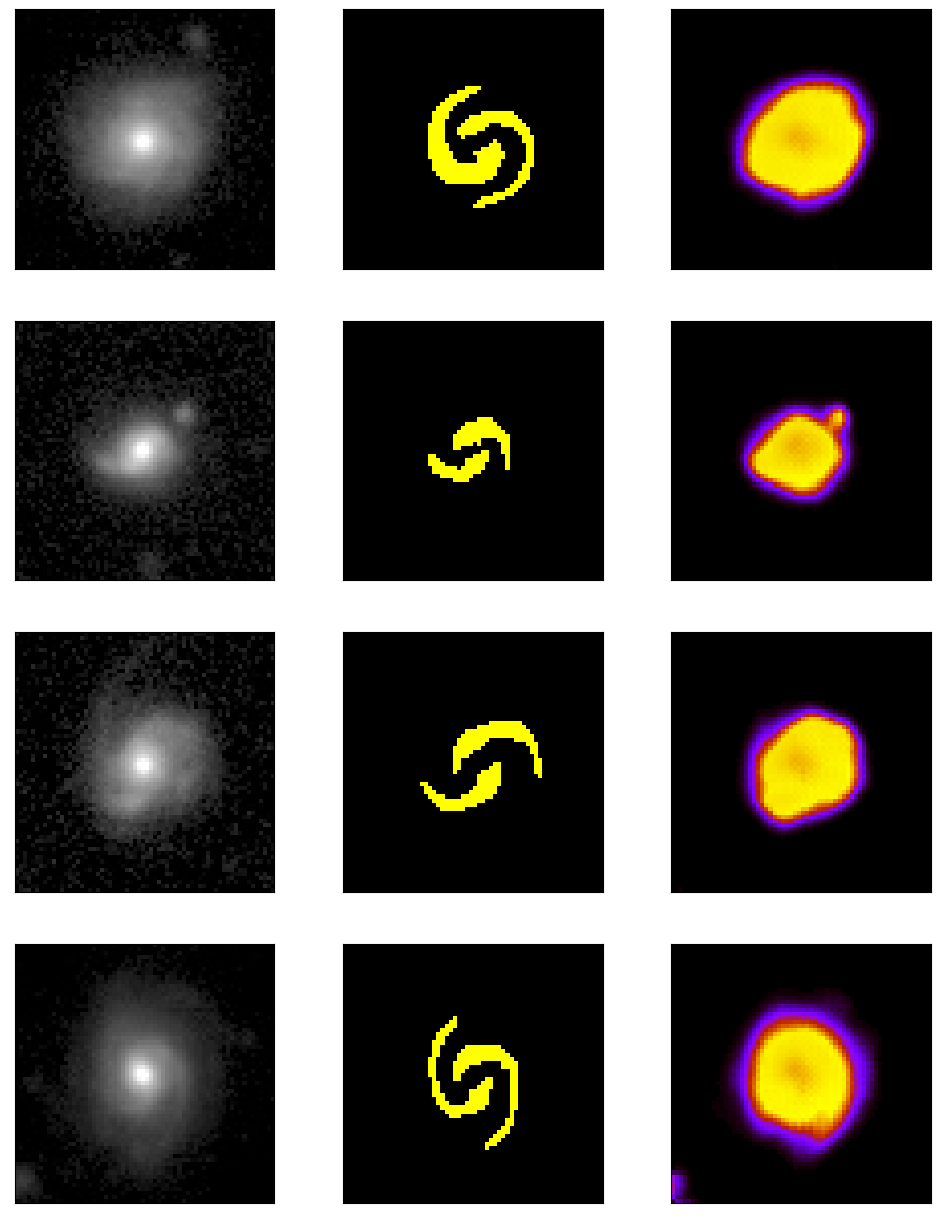

In [8]:
test_preds = model.predict(test_ds)

plt.figure(figsize=(12,60))

for n, (gt_img, gt_mask) in enumerate(test_ds.unbatch().take(15)):
    
    plt.subplot(15,3,3*n+1)
    plt.imshow(gt_img, cmap='gray', alpha=1)
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    
    plt.subplot(15,3,3*n+2)
    plt.imshow(gt_mask, cmap='gnuplot', alpha=1)
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    
    plt.subplot(15,3,3*n+3)
    plt.imshow(test_preds[n], cmap='gnuplot', alpha=1)
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    
plt.show()

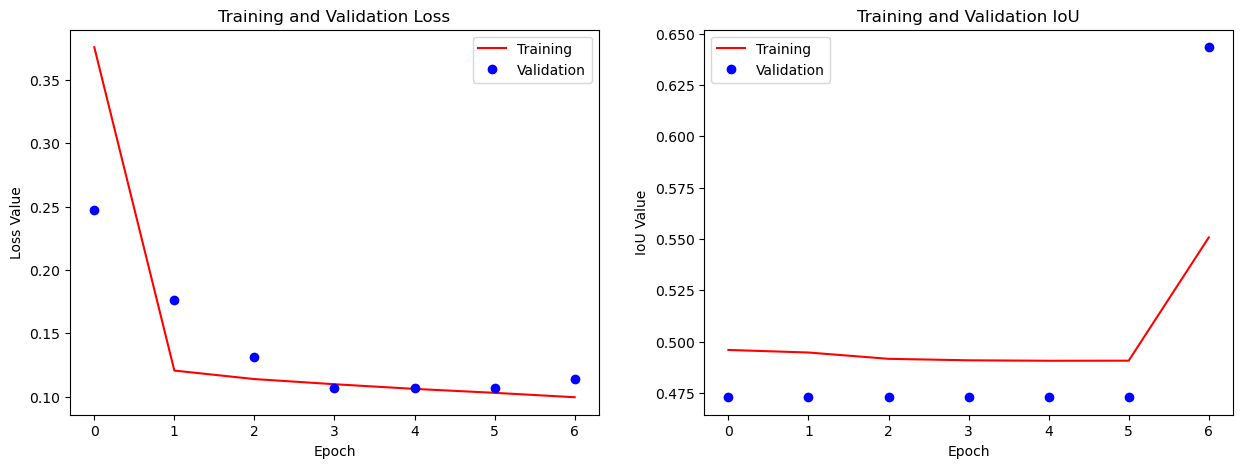

In [9]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15,5))

epochs = range(len(model_history.history['loss']))
loss = model_history.history['loss']
val_loss = model_history.history['val_loss']

ax[0].plot(epochs, loss, 'r', label='Training')
ax[0].plot(epochs, val_loss, 'bo', label='Validation')
ax[0].set_title('Training and Validation Loss')
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Loss Value')
ax[0].legend()

iou = model_history.history['Binary IoU']
val_iou = model_history.history['val_Binary IoU']

ax[1].plot(epochs, iou, 'r', label='Training')
ax[1].plot(epochs, val_iou, 'bo', label='Validation')
ax[1].set_title('Training and Validation IoU')
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('IoU Value')
ax[1].legend()
plt.show()